# ESP32 + INMP441: TensorFlow CNN for sound classification
### Подготовил: Степанюк Денис Борисович

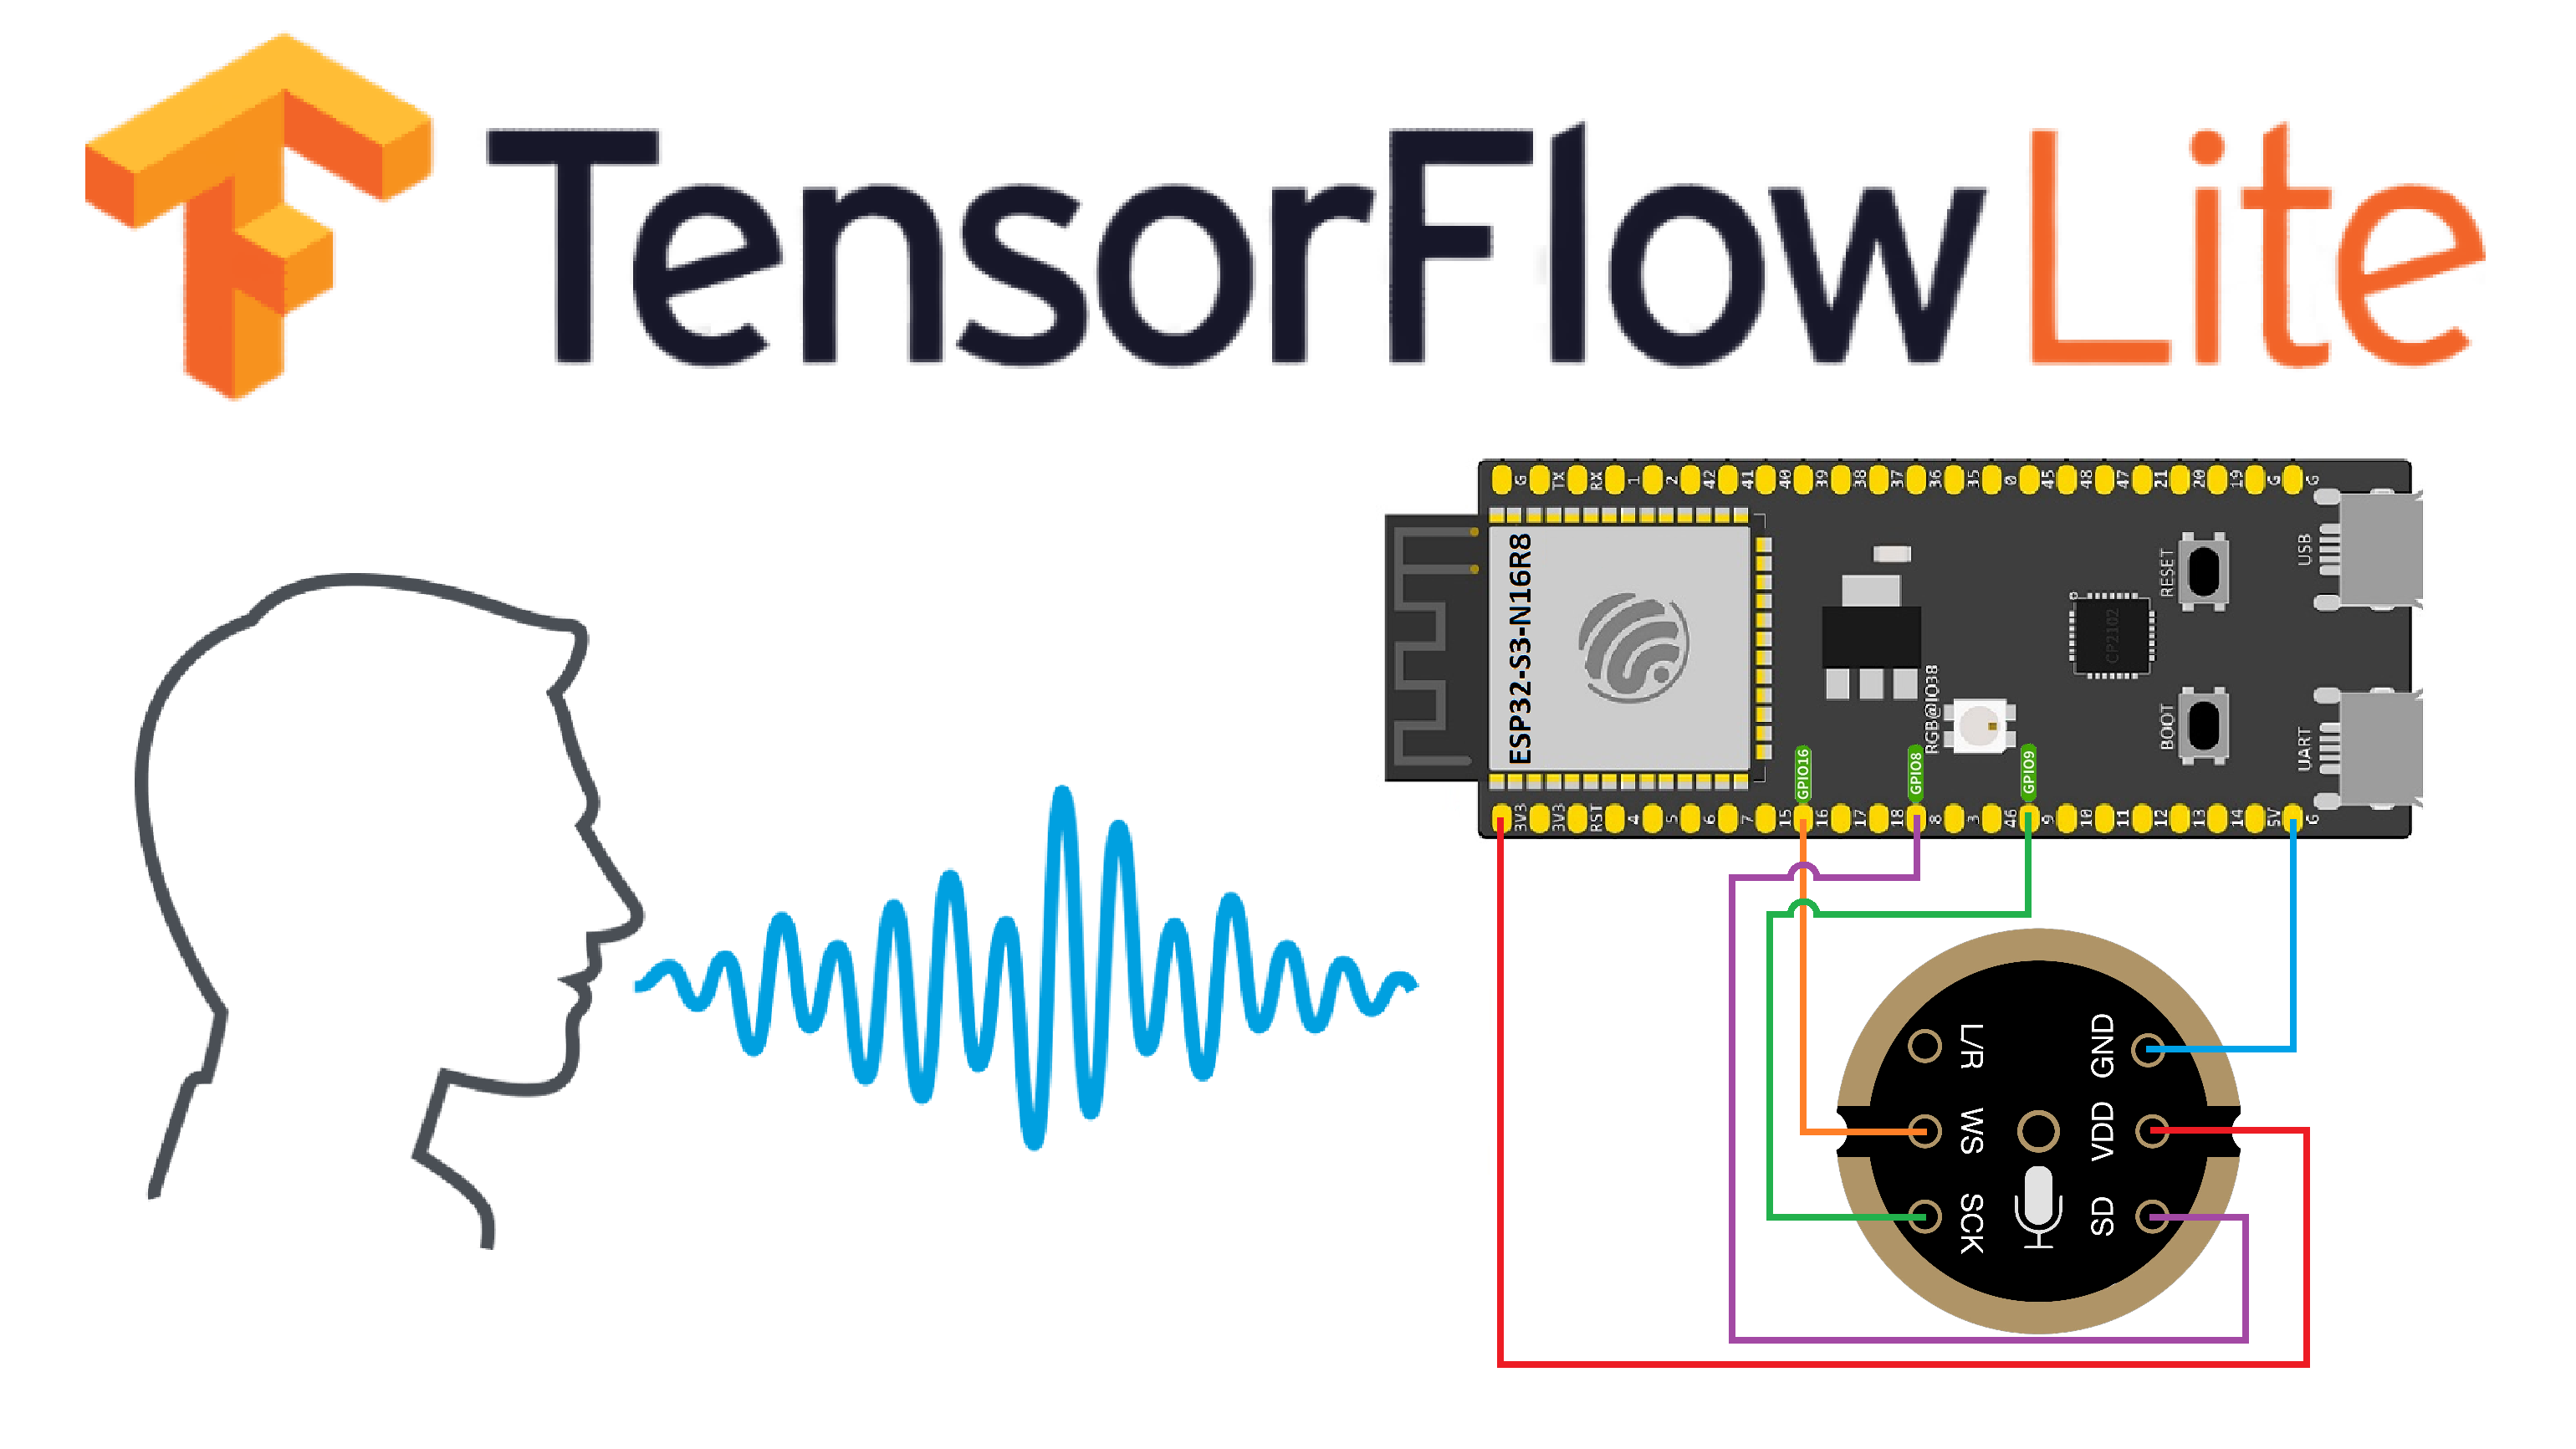

# Загрузка данных

In [1]:
import os
import numpy as np
import tensorflow as tf


def load_audio_dataset(dataset_path='./Dataset', verbose=True):  
    # Get list of class labels from subdirectories
    labels = sorted([d for d in os.listdir(dataset_path) 
                     if os.path.isdir(os.path.join(dataset_path, d))])
    num_labels = len(labels)
    
    
    # Lists to store data
    X_data = []      # Audio waveforms
    Y_labels = []    # Label strings
    file_paths = []  # Keep track of file paths
    
    # Iterate through each class folder
    for label in labels:
        folder_path = os.path.join(dataset_path, label)
        
        # Get all .wav files in this folder
        files = sorted([f for f in os.listdir(folder_path) if f.endswith('.wav')])
        
        
        # Process each audio file
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            
            try:
                # Load audio file
                audio_binary = tf.io.read_file(file_path)
                audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
                
                # Remove channel dimension: (samples, 1) -> (samples,)
                audio = tf.squeeze(audio, axis=-1)
                
                # Normalize to [-1, 1]
                audio = tf.cast(audio, tf.float32)
                audio = audio - tf.reduce_mean(audio)
                max_val = tf.reduce_max(tf.abs(audio))
                audio = tf.where(max_val > 0, audio / max_val, audio)
                
                # Store data
                X_data.append(audio.numpy())
                Y_labels.append(label)
                
            except Exception as e:
                print(f"   ✗ Error loading {file_name}: {e}")
                continue
    

    
    return X_data, Y_labels, labels

# Load the dataset
X_data, Y_labels, label_names = load_audio_dataset(dataset_path='./Dataset')

# Создание спектрограммы с помощью оконного преобразования Фурье
Сигнал разбивается на части, которые перекрываются, и затем производится преобразование Фурье, чтобы рассчитать величину частотного спектра для каждой части. Каждая часть соответствует вертикальной линии на изображении — значение амплитуды в зависимости от частоты в каждый момент времени. Спектры или временные графики располагаются рядом на изображении.
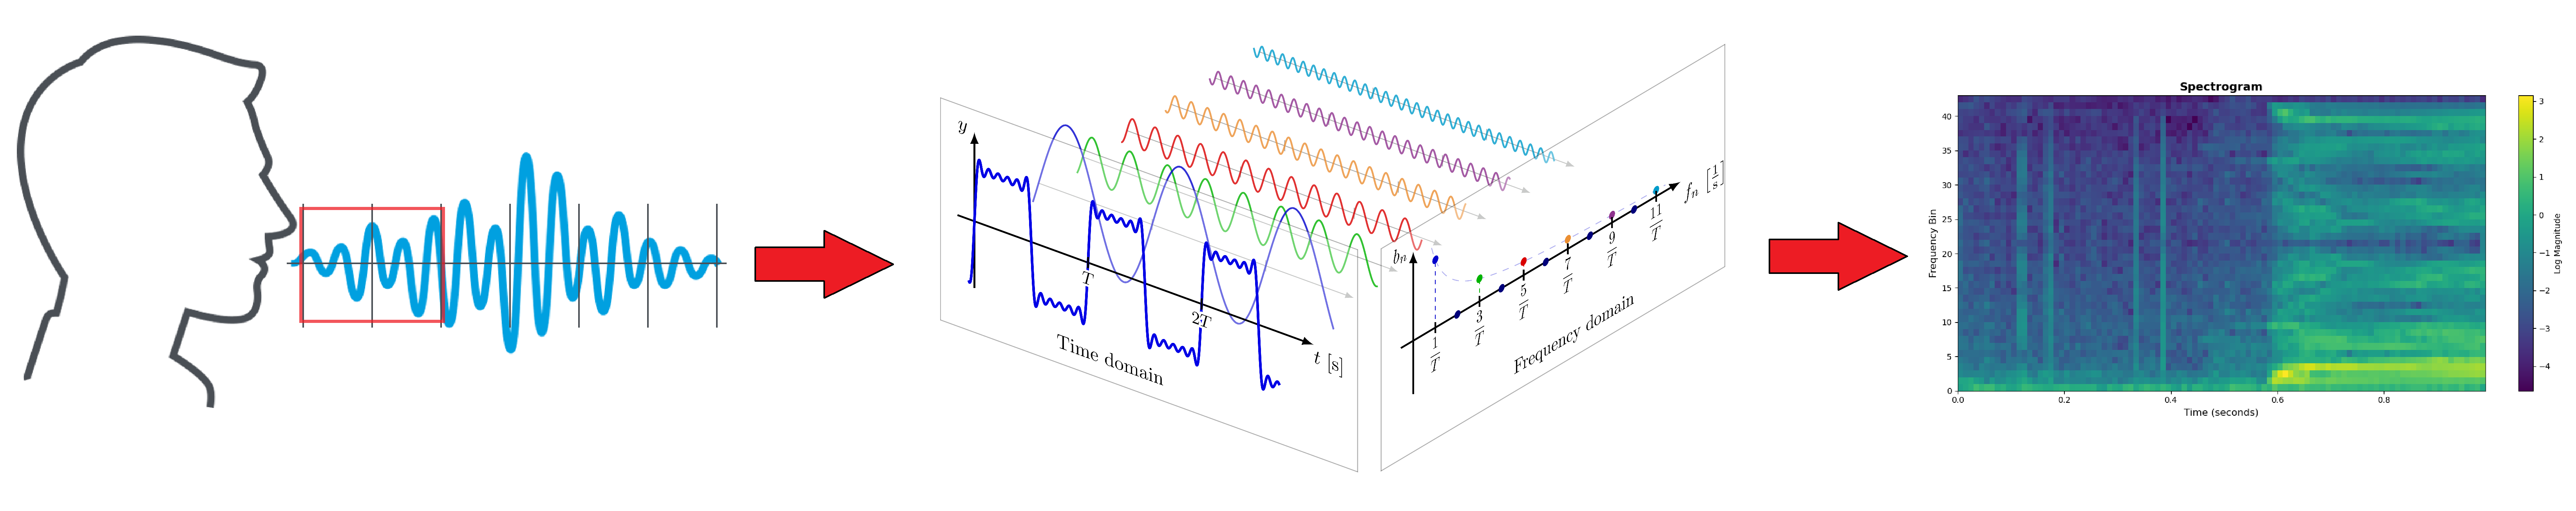

In [2]:
from tensorflow.python.ops import gen_audio_ops as audio_ops

def get_spectrogram_original(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))

    audio = audio.reshape(-1, 1)
    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    
    # Remove batch dimension [batch, time, freq, channel] -> [time, freq, channel]
    spectrogram = spectrogram[0]
    
    spectrogram = tf.squeeze(spectrogram, axis=-1)
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram[:,:41]

# Отображение данных (аудио + аудиодорожка + спектрограмма)

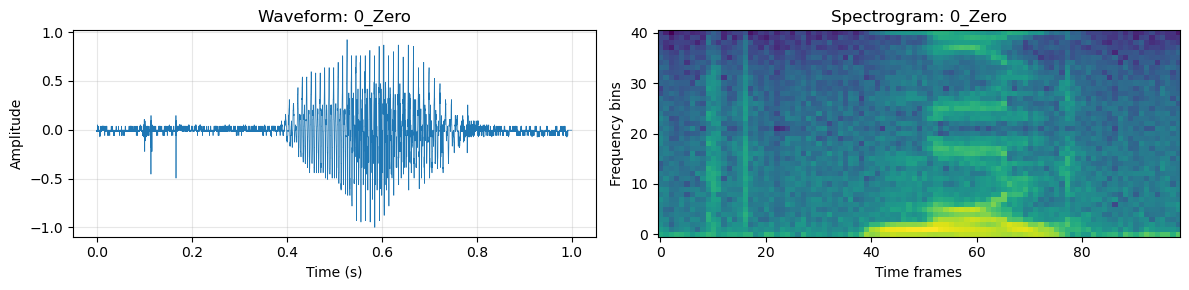

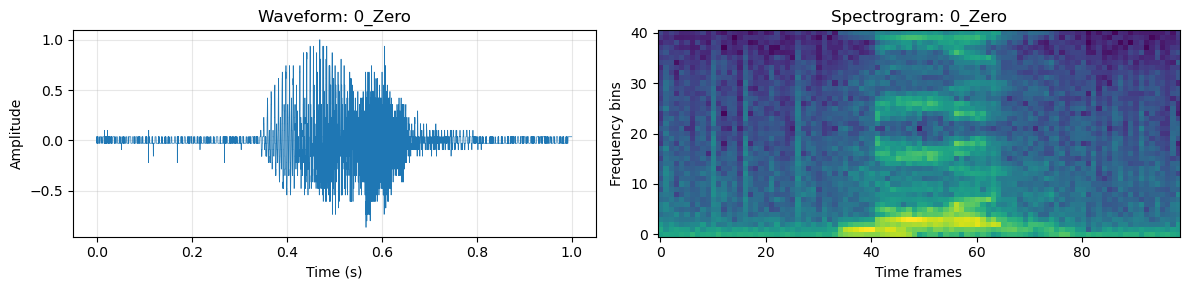

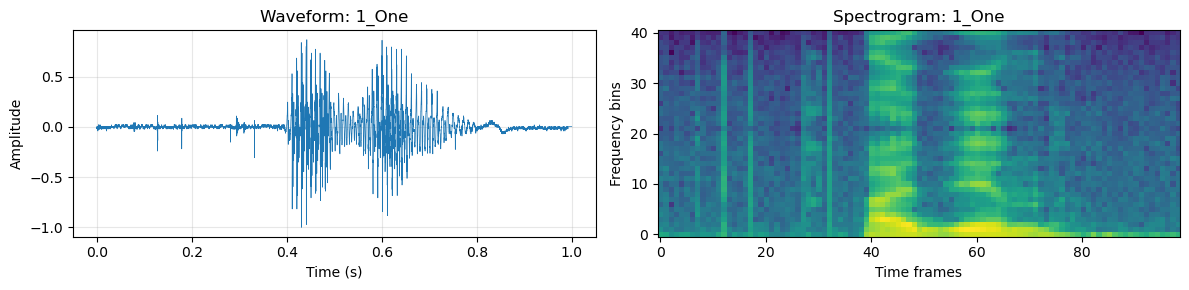

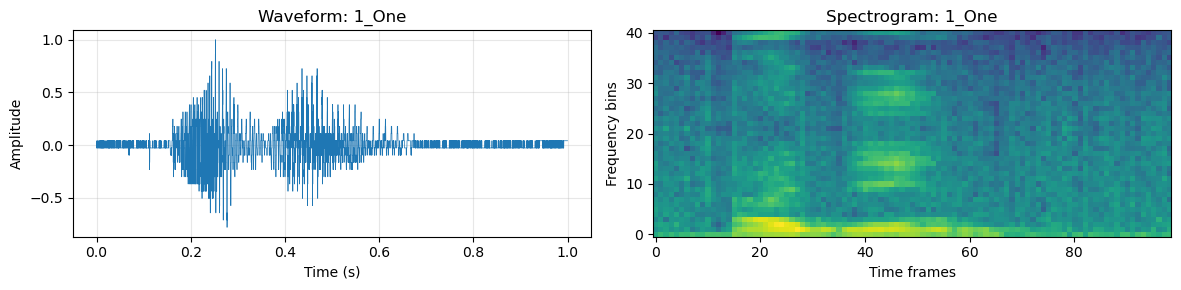

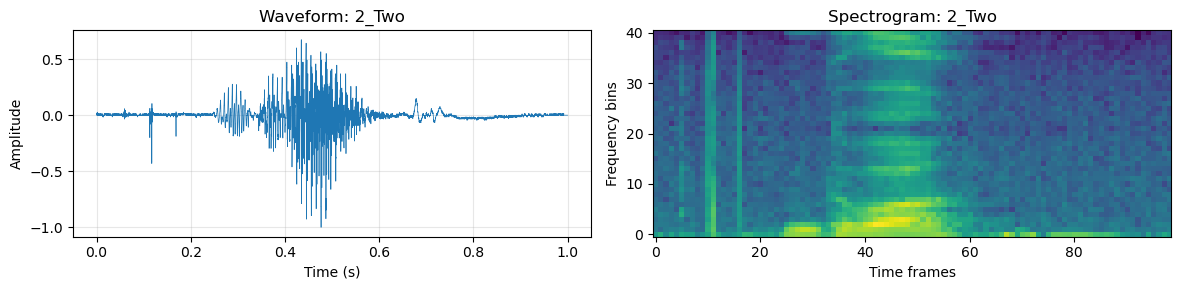

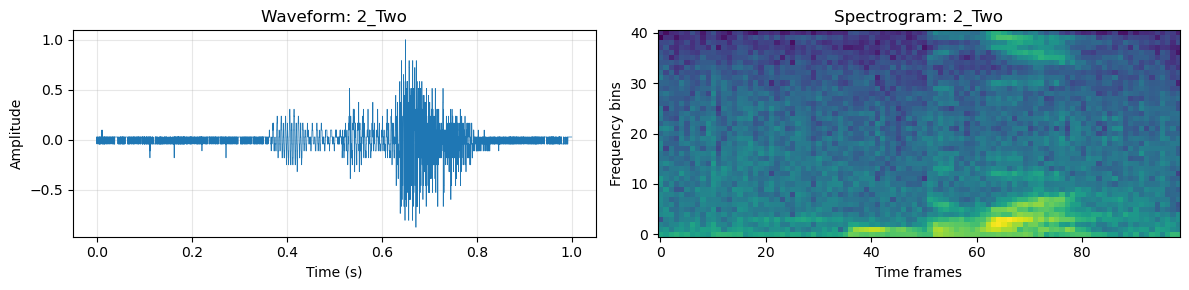

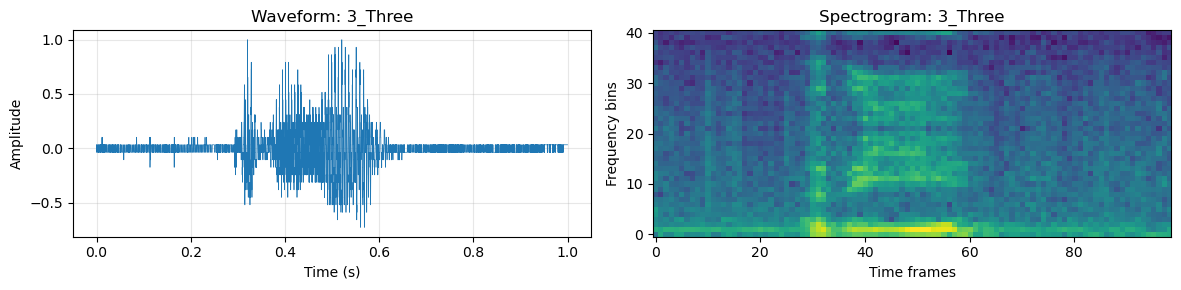

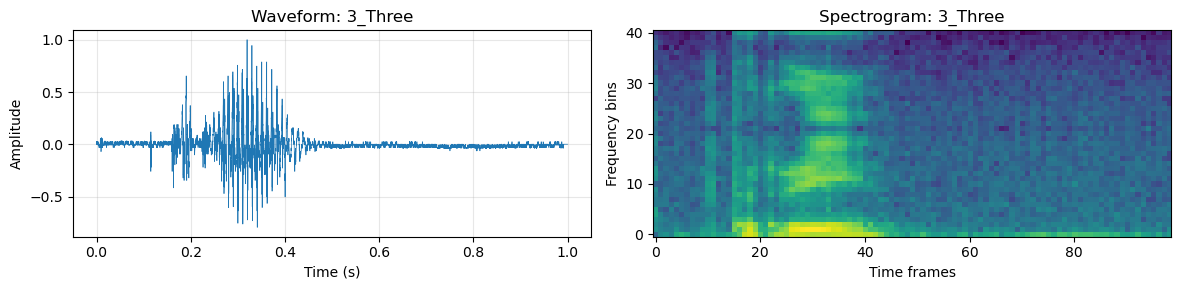

In [3]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML


def show_example(audio, label, sample_rate=16000):
    """
    1) Аудиоплеер
    2) График: [ Waveform | Spectrogram ] в одной строке
    """

    # ----------------
    # AUDIO PLAYER
    # ----------------
    display(HTML(f"<h2 style='color:#0077ff;'>Label: {label}</h2>"))
    display(Audio(audio, rate=sample_rate))

    # ----------------
    # GRAPHIC BLOCK
    # ----------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    # ---- waveform ----
    duration = len(audio) / sample_rate
    time = np.linspace(0, duration, len(audio))

    axs[0].plot(time, audio, linewidth=0.5)
    axs[0].set_title("Waveform: " + label)
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True, alpha=0.3)

    # ---- spectrogram ----
    spec = get_spectrogram_original(audio)

    axs[1].imshow(spec.T, aspect="auto", origin="lower", cmap="viridis")
    axs[1].set_title("Spectrogram: " + label)
    axs[1].set_xlabel("Time frames")
    axs[1].set_ylabel("Frequency bins")
    plt.tight_layout()
    plt.show()


# -------------------------------------
# ВЫВОД ДЛЯ ДАТАСЕТА
# -------------------------------------

for label in label_names:

    idx = np.where(np.array(Y_labels) == label)[0]
    chosen = idx[:2]  # два примера

    for j in chosen:
        audio = X_data[j]
        show_example(audio, label)

# Аугментация данных 
Метод искусственного увеличения обучающей выборки за счёт создания новых, немного изменённых копий существующих данных.

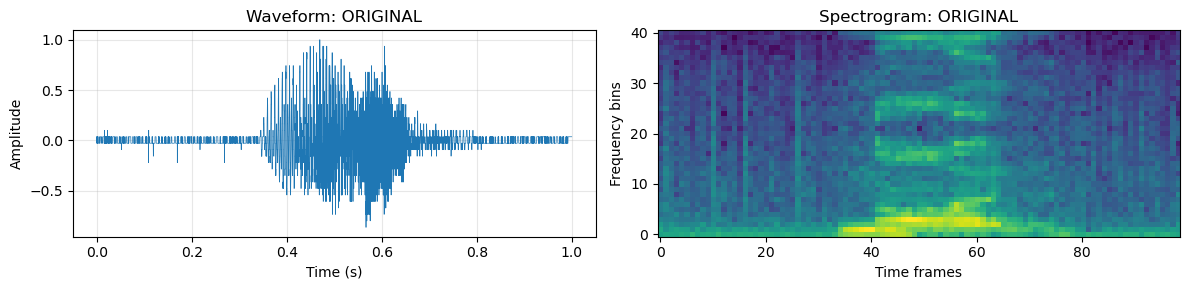

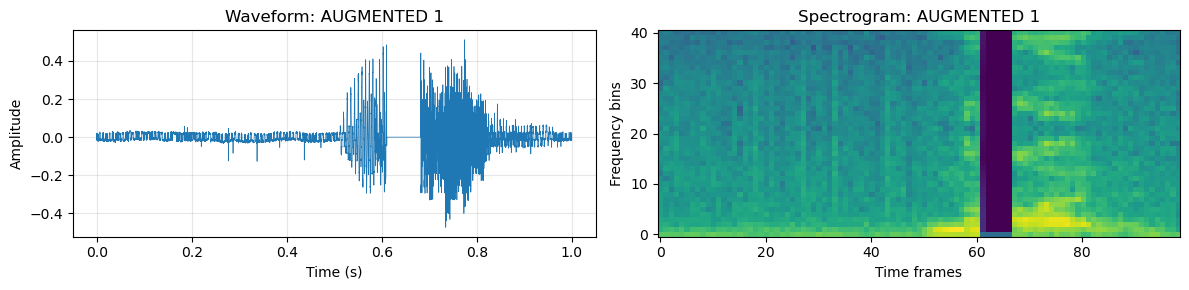

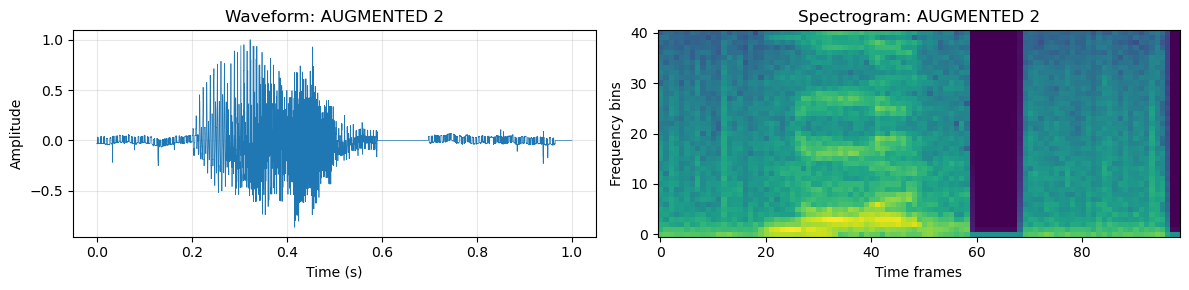

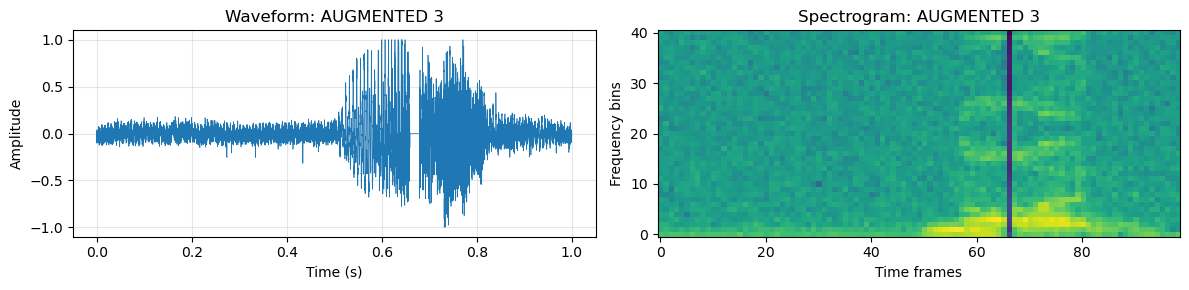

In [4]:
 def _time_shift(audio, sample_rate=16000):
    """Apply random time shift augmentation."""
    max_shift = int(0.2 * sample_rate)  # ±0.2 seconds
    shift = tf.random.uniform([], -max_shift, max_shift, dtype=tf.int32)
    audio = tf.roll(audio, shift=shift, axis=0)
    return audio
    
def _add_white_noise(audio, intensity=None, sample_rate=16000):
    """Add white noise to audio."""
    if intensity is None:
        intensity = tf.random.uniform([], 0.0, 0.05)
    noise = tf.random.normal(tf.shape(audio), stddev=intensity)
    return audio + noise
    
def _add_pink_noise(audio, intensity=None, sample_rate=16000):
    """Add pink noise (1/f noise) to audio."""
    if intensity is None:
        intensity = tf.random.uniform([], 0.0, 0.05)
        
    # Generate white noise
    white = tf.random.normal(tf.shape(audio))
        
    # Apply 1/f filter in frequency domain (approximation)
    # For simplicity, we'll use a filtered version
    fft = tf.signal.rfft(white)
    freqs = tf.range(1, tf.shape(fft)[0] + 1, dtype=tf.float32)
    # Pink noise: amplitude proportional to 1/sqrt(f)
    pink_filter = 1.0 / tf.sqrt(freqs)
    pink_fft = fft * tf.cast(pink_filter, tf.complex64)
    pink = tf.signal.irfft(pink_fft)
        
    # Normalize and scale
    pink = pink - tf.reduce_mean(pink)
    pink = pink / (tf.reduce_max(tf.abs(pink)) + 1e-8)
        
    return audio + pink * intensity
    
def _add_brown_noise(audio, intensity=None, sample_rate=16000):
    """Add brown noise (Brownian/red noise) to audio."""
    if intensity is None:
        intensity = tf.random.uniform([], 0.0, 0.05)
        
    # Generate white noise
    white = tf.random.normal(tf.shape(audio))
        
    # Apply 1/f^2 filter
    fft = tf.signal.rfft(white)
    freqs = tf.range(1, tf.shape(fft)[0] + 1, dtype=tf.float32)
    # Brown noise: amplitude proportional to 1/f
    brown_filter = 1.0 / freqs
    brown_fft = fft * tf.cast(brown_filter, tf.complex64)
    brown = tf.signal.irfft(brown_fft)
        
    # Normalize and scale
    brown = brown - tf.reduce_mean(brown)
    brown = brown / (tf.reduce_max(tf.abs(brown)) + 1e-8)
        
    return audio + brown * intensity
    
def _add_background_noise(audio, sample_rate=16000):
    """Add random background noise (white, pink, or brown)."""
    noise_type = tf.random.uniform([], 0, 3, dtype=tf.int32)
    intensity = tf.random.uniform([], 0.0, 0.1)
        
    if noise_type == 0:
        return _add_white_noise(audio, intensity)
    elif noise_type == 1:
        return _add_pink_noise(audio, intensity)
    else:
        return _add_brown_noise(audio, intensity)
    
def _random_gain(audio, sample_rate=16000):
    """Apply random gain/volume change."""
    gain_db = tf.random.uniform([], -6.0, 6.0)
    gain_linear = tf.pow(10.0, gain_db / 20.0)
    return audio * gain_linear
    
def _pitch_shift(audio, sample_rate=16000):
    """
    Apply pitch shifting using resampling.
    Note: This is a simplified version using tf.signal operations.
    """
    # Random pitch shift factor (between 0.9 and 1.1 for ±2 semitones approx)
    shift_factor = tf.random.uniform([], 0.95, 1.05)
        
    # Resample to shift pitch
    new_length = tf.cast(tf.cast(tf.shape(audio)[0], tf.float32) * shift_factor, tf.int32)
        
    # Use linear interpolation for resampling
    indices = tf.linspace(0.0, tf.cast(tf.shape(audio)[0] - 1, tf.float32), new_length)
    
    # Simple linear interpolation
    lower = tf.cast(tf.floor(indices), tf.int32)
    upper = tf.minimum(lower + 1, tf.shape(audio)[0] - 1)
    weight = indices - tf.floor(indices)
        
    audio_shifted = (1.0 - weight) * tf.gather(audio, lower) + weight * tf.gather(audio, upper)
        
    # Pad or trim to original length
    if new_length > sample_rate:
        audio_shifted = audio_shifted[:sample_rate]
    elif new_length < sample_rate:
        padding = sample_rate - new_length
        audio_shifted = tf.pad(audio_shifted, [[0, padding]])
        
    return audio_shifted
    
def _time_masking(audio, sample_rate=16000):
    """Apply time masking by zeroing out a random segment."""
    max_mask_length = sample_rate // 8  # Max 1/8 of audio
    mask_length = tf.random.uniform([], 0, max_mask_length, dtype=tf.int32)
        
    max_start = sample_rate - mask_length
    start_pos = tf.random.uniform([], 0, max_start, dtype=tf.int32)
        
    # Create mask
    mask = tf.ones_like(audio)
    indices = tf.range(tf.shape(audio)[0])
    mask = tf.where(
        (indices >= start_pos) & (indices < start_pos + mask_length),
        tf.zeros_like(audio),
        mask
        )
        
    return audio * mask
    
def _apply_augmentation(audio):
    """Apply all augmentations randomly."""
    # Time shift (50% probability)
    if tf.random.uniform([]) > 0.1:
        audio = _time_shift(audio)
        
    # Background noise (50% probability)
    if tf.random.uniform([]) > 0.3:
        audio = _add_background_noise(audio)
        
    # Random gain (50% probability)
    if tf.random.uniform([]) > 0.3:
        audio = _random_gain(audio)
        
    # Pitch shift (30% probability)
    if tf.random.uniform([]) > 0.5:
        audio = _pitch_shift(audio)
        
    # Time masking (30% probability)
    if tf.random.uniform([]) > 0.01:
        audio = _time_masking(audio)
        
    # Clip to [-1, 1]
    audio = tf.clip_by_value(audio, -1.0, 1.0)
        
    return audio.numpy()

test_augm_1 = _apply_augmentation(X_data[1])
test_augm_2 = _apply_augmentation(X_data[1])
test_augm_3 = _apply_augmentation(X_data[1])
show_example(X_data[1], "ORIGINAL")
show_example(test_augm_1, "AUGMENTED 1")
show_example(test_augm_2, "AUGMENTED 2")
show_example(test_augm_3, "AUGMENTED 3")

### Разделить датасет на тренировочную и валидационную выборки

In [5]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части.
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_labels, train_size = 0.8)

### Произвести аугментацию тренировочной части датасета

In [6]:
import random

X_train_data_augm = []      # Audio waveforms
Y_train_labels_augm = []    # Label strings

for X, Y in zip(X_train, Y_train):
    for i in range(10):
        X_train_data_augm.append(_apply_augmentation(X))
        Y_train_labels_augm.append(Y)

# Объеденить оригинальные и аугментированные данные
X_train.extend(X_train_data_augm)
Y_train.extend(Y_train_labels_augm)

# Перемешать случайным образом
indices = list(range(len(Y_train)))
random.shuffle(indices)

X_train = [X_train[i] for i in indices]
Y_train = [Y_train[i] for i in indices]

### Подготовить данные для передачи на вход свёрточной нейронной сети

In [7]:
import pandas as pd

# Преобразуем категориальные текстовые метки (правильные ответы) в бинарные вектора.
Y_train_binary = pd.get_dummies(Y_train)
Y_test_binary = pd.get_dummies(Y_test)

X_spectrogram_train = []
for X in X_train:
    spectrogram = get_spectrogram_original(X)
    # Добавим измерение канала (например, (24,32,1))
    spectrogram = np.expand_dims(spectrogram, axis=-1)
    
    X_spectrogram_train.append(spectrogram)

X_spectrogram_train = np.array(X_spectrogram_train)


X_spectrogram_test = []
for X in X_test:
    spectrogram = get_spectrogram_original(X)
    # Добавим измерение канала (например, (24,32,1))
    spectrogram = np.expand_dims(spectrogram, axis=-1)
    
    X_spectrogram_test.append(spectrogram)

X_spectrogram_test = np.array(X_spectrogram_test)


# Размеры спектрограммы:
IMAGE_HEIGHT = X_spectrogram_train.shape[1]
IMAGE_WIDTH = X_spectrogram_train.shape[2]
CHANNELS = 1

NUM_of_LABELS = len(label_names)

# СВЁРТОЧНЫЕ НЕЙРОННЫЕ СЕТИ
**Свёрточная нейронная сеть — это особый тип реализации искусственного интеллекта, который использует специальную математическую операцию, называемую свёрткой, для обработки данных из изображений.**

* **Свёртка выполняется путём перемножения двух матриц и получения третьей, меньшей матрицы.**
* **Сеть принимает входное изображение и использует фильтр (или ядро) для создания карты признаков, описывающей изображение.**
* **В операции свёртки фильтр (обычно матрица 2x2 или 3x3) скользит по матрице изображения. Соответствующие числа в обеих матрицах перемножаются и складываются, образуя одно число, описывающее данный участок изображения. Этот процесс повторяется для всего изображения. Принцип работы показан на следующей иллюстрации.**

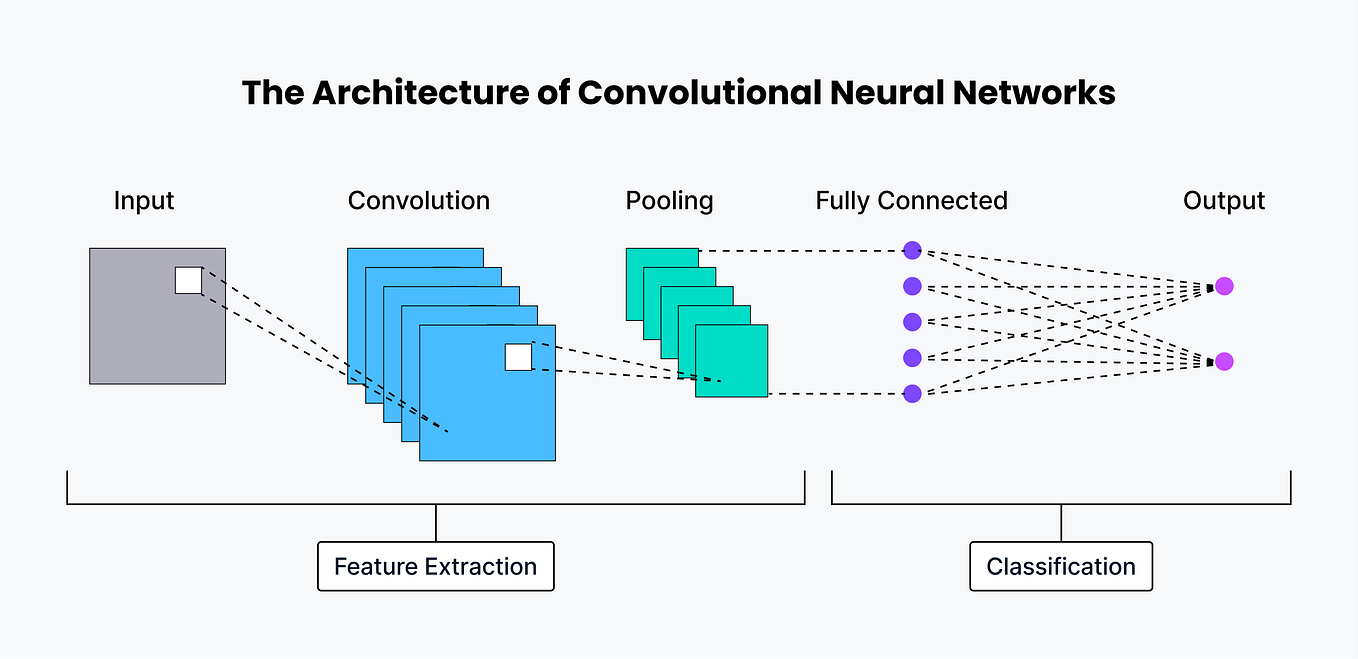

# Обучение модели CNN

In [8]:
# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

### Структура модели

In [9]:
# Инициализация модели.
model_CNN = Sequential()

# 1-й свёрточный слой (вход молели).
model_CNN.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
# Слой максимального пулинга для 1-го свёрточного слоя.
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 2-й свёрточный слой.
model_CNN.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
#model_CNN.add(Dropout(0))
# Слой максимального пулинга для 2-го свёрточного слоя.
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 2-й свёрточный слой.
model_CNN.add(Conv2D(8 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
#model_CNN.add(Dropout(0))
# Слой максимального пулинга для 2-го свёрточного слоя.
model_CNN.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Cлой для преобразования многомерных данных в одномерный вектор. 
model_CNN.add(Flatten())

# 1-й полносвязный слой.
model_CNN.add(Dense(units = 16 , activation = 'relu'))
# Отключить 30% случайных нейронов в слое во время обучения. 
model_CNN.add(Dropout(0))

# 2-й полносвязный слой (выход модели).
model_CNN.add(Dense(units = NUM_of_LABELS , activation = 'softmax'))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model_CNN.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 41, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 21, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 21, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 11, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 11, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 6, 8)          0

### Обучение модели

In [10]:
# Кол-во итераций обучения.
Epochs = 30

# Запустить обучение модели.
history = model_CNN.fit(X_spectrogram_train, Y_train_binary, epochs = Epochs, 
                        validation_data = (X_spectrogram_test, Y_test_binary), callbacks = [learning_rate_reduction])

# Сохранить модель.
model_CNN.save('model_CNN.h5')

Epoch 1/30
55/55 [==============================] - 2s 21ms/step - loss: 1.2889 - accuracy: 0.4307 - val_loss: 0.8411 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 1s 19ms/step - loss: 0.5339 - accuracy: 0.8210 - val_loss: 0.2211 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 1s 18ms/step - loss: 0.2663 - accuracy: 0.9159 - val_loss: 0.1752 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 1s 18ms/step - loss: 0.1498 - accuracy: 0.9568 - val_loss: 0.1991 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 1s 18ms/step - loss: 0.0992 - accuracy: 0.9722 - val_loss: 0.1797 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 1s 18ms/step - loss: 0.0683 - accuracy: 0.9784 - val_loss: 0.1562 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/30
55/55 [==============================] - 1s 18ms/step - loss: 0.0

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model_CNN.evaluate(X_spectrogram_test, Y_test_binary)[1]*100 , "%")

2/2 [==============================] - 0s 5ms/step - loss: 0.2664 - accuracy: 0.9750
Accuracy of the model is -  97.50000238418579 %


# Анализ процесса обучения модели

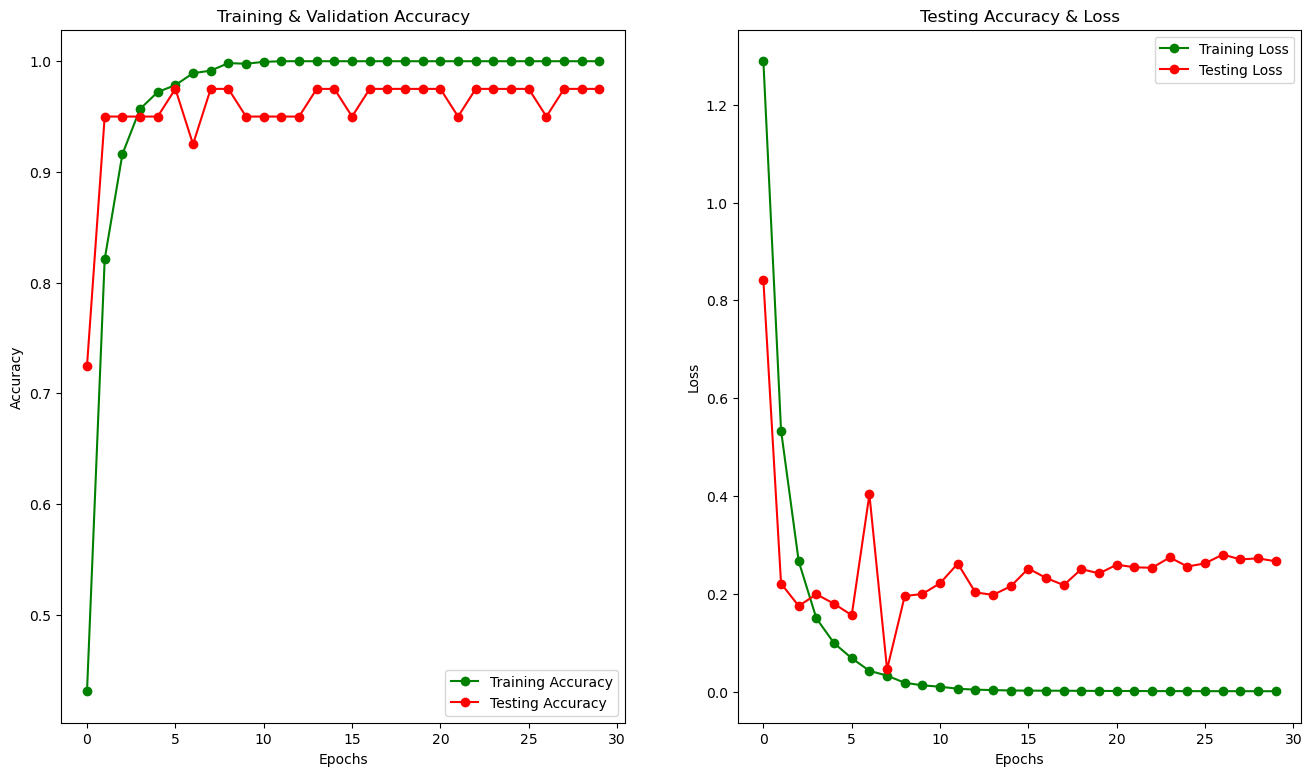

In [12]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Confusion matrix (матрица ошибок) 
### Таблица, которая показывает, как именно модель путает классы.

In [13]:
import itertools

def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

2/2 [==============================] - 0s 4ms/step


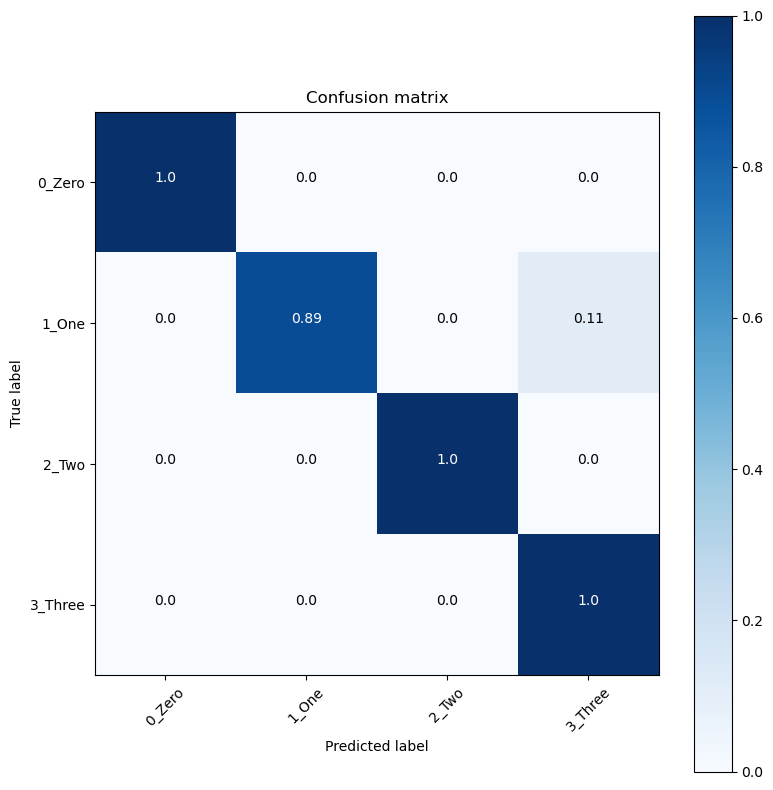

In [14]:
# 1. Получаем предсказания
predictions = model_CNN.predict(X_spectrogram_test)

# 2. Превращаем one-hot в метки
y_true = tf.argmax(Y_test_binary, axis=1)
y_pred = tf.argmax(predictions, axis=1)

# 3. Строим матрицу ошибок
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)

# 4. Выводим матрицу ошибок
plot_confusion_matrix(cm, label_names)

# Конвертируем модель в облегчённый формат
### Подготавливаем репрезентативную выборку

In [15]:
def representative_dataset():
    for i in range(len(X_train)):
        # Оборачиваем каждую строку в batch размером (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS).
        data = np.expand_dims(X_spectrogram_train[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), axis=0).astype(np.float32)
        yield [data]

### Конвертируем модель

In [16]:
# Платформа для машинного обучения, разработанная Google, которая предоставляет инструменты для создания, 
# обучения и развертывания моделей машинного и глубокого обучения
import tensorflow as tf

# Передаём модель в конвертер.
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN)

# Передаём репрезентативную выборку в конвертер.
converter.representative_dataset = representative_dataset

# Указываем оптимизатор для модели.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Передаём набор встроенных операций, которые поддерживают 8-битные целочисленные (от -128 до 127) вычисления. 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Указываем что вход модели отныне принимает 8-битный целочисленный тип данных (от -128 до 127).
#converter.inference_input_type = tf.int8
converter.inference_input_type = tf.float32
# Указываем что выход модели отныне выдаёт 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmp252nuzoq\assets


INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmp252nuzoq\assets
C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [17]:
# Сохранить облегчённую модель.
open("model_CNN.tflite", "wb").write(tflite_model)

19776

### xxd -i model_CNN.tflite > model.cc

##### Команда для текстового редактора "vim", которая преобразует бинарный файл "model_CNN.tflite" в C/C++ формат "model.cc" для того чтобы модель можно было использовать как массив байтов в исходном коде для ESP32.

In [18]:
!xxd -i model_CNN.tflite > model.cc

### Оценим качество облегчённой модели

In [19]:
# Путь к сохранённой облегчённой модели.
tflite_model_path = "model_CNN.tflite"

# Загрузка модели и выделение памяти под тензоры.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Получить входной и выходной тензоры.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Параметры для масштабирования 
input_scale, input_zero_point = input_details[0]['quantization']

# Вывести размеры входного и выходного тензора.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 99 41  1]
[1 4]


In [20]:
input_scale, input_zero_point = input_details[0]['quantization']
print(input_scale)
print(input_zero_point)

0.0
0


In [21]:
# Список для всех предсказаний.
predictions = []

# Предскажем классы для всей тестовой выборки.
for i in range(X_spectrogram_test.shape[0]):
    # Передаём данные(отмасштабируем данные [0 : 100] --> [-128 : 127]).
    #X_input = np.int8(((X_test[i]-50)/50)*127.5).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
    X_input = X_spectrogram_test[i]
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_input, axis=0))
    interpreter.invoke()
    # Получаем результат.
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    # Сохраним предсказания.
    predictions.append(tflite_model_predictions[0])
    
    print("Prediction ", i, ": ", tflite_model_predictions[0])
    predicted = np.argmax(tflite_model_predictions, axis=1)[0]
    print("predicted_class:",predicted,"( ", label_names[predicted], " )")
    correct = np.argmax(Y_test_binary.iloc[i].values)
    print("correct_class:",correct,"( ", label_names[correct], " )")
    print("------------------------------------")

Prediction  0 :  [ 127 -128 -128 -128]
predicted_class: 0 (  0_Zero  )
correct_class: 0 (  0_Zero  )
------------------------------------
Prediction  1 :  [-112 -128  112 -128]
predicted_class: 2 (  2_Two  )
correct_class: 2 (  2_Two  )
------------------------------------
Prediction  2 :  [ 127 -128 -128 -128]
predicted_class: 0 (  0_Zero  )
correct_class: 0 (  0_Zero  )
------------------------------------
Prediction  3 :  [-128 -128  127 -128]
predicted_class: 2 (  2_Two  )
correct_class: 2 (  2_Two  )
------------------------------------
Prediction  4 :  [-128  127 -128 -128]
predicted_class: 1 (  1_One  )
correct_class: 1 (  1_One  )
------------------------------------
Prediction  5 :  [ 127 -128 -128 -128]
predicted_class: 0 (  0_Zero  )
correct_class: 0 (  0_Zero  )
------------------------------------
Prediction  6 :  [-128  127 -128 -128]
predicted_class: 1 (  1_One  )
correct_class: 1 (  1_One  )
------------------------------------
Prediction  7 :  [-128 -128  127 -128]
pre

In [22]:
# Оценим качество облегчённой модели сравнив предсказания с правильными ответами.
from sklearn.metrics import accuracy_score
acc = accuracy_score(np.argmax(predictions, axis=1), np.argmax(Y_test_binary, axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.975
